In [54]:
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append("../")
from recsys import config

In [55]:
df = pd.read_csv(config.PROCESSED_DATA_DIR / "grouped_transactions.csv")
print(len(df))
df.head()

902242


,customer_id,articles
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,"[568601006, 568601006, 745232001, 795440001]"
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,"[673677002, 723529001, 640021012, 351484002, 6..."
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[351484002, 351484002, 723529001]"
3,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,[730683050]
4,000064249685c11552da43ef22a5030f35a147f723d5b0...,"[738133005, 680265002]"


## Preprocessing

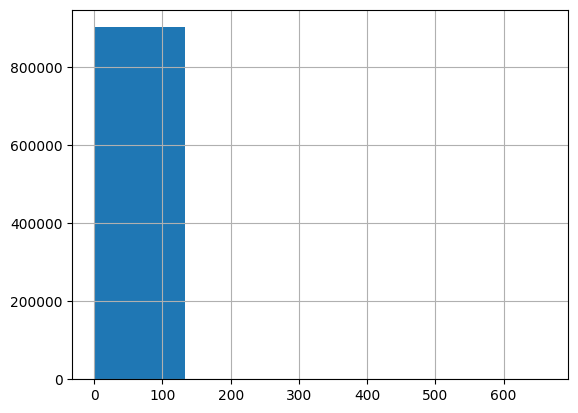

In [56]:
df["sequence_length"] = df["articles"].apply(lambda x: len(x.split(",")))
df["sequence_length"].hist(bins=5)
plt.show()

In [57]:
df["sequence_length"].describe()

count    902242.000000
mean          6.398179
std           8.137770
min           1.000000
25%           2.000000
50%           4.000000
75%           8.000000
max         662.000000
Name: sequence_length, dtype: float64

In [58]:
max_sequence_length = 10
max_sequence_mask =df["sequence_length"] > max_sequence_length


df[max_sequence_mask].shape, df[
    max_sequence_mask
].shape[0] / df.shape[0] * 100

((158782, 3), 17.598604365569326)

In [59]:
min_sequence_length = 2
min_sequence_mask = df["sequence_length"]< min_sequence_length

print(df[min_sequence_mask].shape[0])
df[min_sequence_mask].shape[0] / df.shape[0] * 100

206832


22.924226537891165

In [60]:
df = df[~min_sequence_mask & ~max_sequence_mask]
df.shape[0]

536628

In [61]:
df.to_csv(config.PROCESSED_DATA_DIR / "grouped_transactions_filtered.csv", index=False)

# Transformer decoder
for predicting the next token in a sequence. The model is based on the paper "Attention is All You Need" by Vaswani et al. (2017). The model is implemented in PyTorch.

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import ast
import sys
import time

sys.path.append("../")
from recsys import config

2024-12-16 23:50:44.773 | INFO     | recsys.config:<module>:11 - PROJ_ROOT path is: /Users/egortarasov/uni/7 семестр/nlp/recsys


In [2]:
df = pd.read_csv(config.PROCESSED_DATA_DIR / "grouped_transactions_filtered.csv")
df.head()

,customer_id,articles,sequence_length
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,"[568601006, 568601006, 745232001, 795440001]",4
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[351484002, 351484002, 723529001]",3
2,000064249685c11552da43ef22a5030f35a147f723d5b0...,"[738133005, 680265002]",2
3,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,"[715624008, 719530003, 448509014]",3
4,00007d2de826758b65a93dd24ce629ed66842531df6699...,"[349301001, 351933001, 578478001, 730683001, 1...",7


## Dataset

In [3]:
unique_articles = set()
for articles in df["articles"]:
    if isinstance(articles, str):
        articles = ast.literal_eval(articles)
    unique_articles.update(articles)

article_id_map = {article_id: idx for idx, article_id in enumerate(unique_articles)}

In [4]:
class CustomerDataset(Dataset):
    def __init__(self, df, max_len, article_id_map):
        self.df = df
        self.max_len = max_len
        self.article_id_map = article_id_map

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        articles = self.df.iloc[idx]["articles"]
        if isinstance(articles, str):
            articles = ast.literal_eval(
                articles
            )
        articles = [
            self.article_id_map[article] for article in articles
        ]
        articles = articles + [0] * (self.max_len - len(articles))  # Padding
        input_seq = torch.tensor(articles[:-1], dtype=torch.long)
        target_seq = torch.tensor(articles[1:], dtype=torch.long)
        return input_seq, target_seq

## Model


In [5]:
class TransformerDecoderModel(nn.Module):
    def __init__(
        self, vocab_size, d_model, nhead, num_decoder_layers, dim_feedforward, max_len
    ):
        super(TransformerDecoderModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = nn.Embedding(max_len, d_model)
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward),
            num_decoder_layers,
        )
        self.fc_out = nn.Linear(d_model, vocab_size)
        self.max_len = max_len

    def forward(self, src, tgt):
        src = self.embedding(src) + self.pos_encoder(
            torch.arange(src.size(1), device=src.device).unsqueeze(0)
        )
        tgt = self.embedding(tgt) + self.pos_encoder(
            torch.arange(tgt.size(1), device=tgt.device).unsqueeze(0)
        )
        output = self.transformer_decoder(tgt, src)
        return self.fc_out(output)

## Train

In [6]:
vocab_size = len(article_id_map)
d_model = 512
nhead = 8
num_decoder_layers = 6
dim_feedforward = 2048
max_len = 50
batch_size = 128
num_epochs = 10
learning_rate = 0.001

In [7]:
if torch.backends.mps.is_available():
    print("MPS backend is available.")
else:
    print("MPS backend is not available.")
device = (
    torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
)

MPS backend is available.


In [8]:
dataset = CustomerDataset(df, max_len, article_id_map)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


model = TransformerDecoderModel(vocab_size, d_model, nhead, num_decoder_layers, dim_feedforward, max_len)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [9]:
def train_model(model, dataloader, criterion, optimizer, num_epochs, device):
    model.train()
    model.to(device)
    for epoch in range(num_epochs):
        for batch_idx, batch in enumerate(dataloader):
            start = time.time()
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs, inputs)
            loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print(f"Batch {batch_idx+1}/{len(dataloader)} processed successfully. in {time.time() - start}", end="\r")
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

In [10]:
train_model(model, dataloader, criterion, optimizer, num_epochs, device)

KeyboardInterrupt: 